# Drug Consumption Final Project for COMP 562 - Random Forest Methods
#### by Samantha Anthony
---

## Import Libraries and Data

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier




drug_labels = ['Alcohol','Amphet','Amyl','Benzos','Caff','Choc','Coke','Crack','Ecstasy','Heroin','Ketamine','Legalh','LSD','Meth','Mushrooms','Nicotine','VSA']
sched_1 = ['Heroin','LSD','Ecstasy','Mushrooms']
sched_2 = ['Amphet','Coke','Crack','Meth']
sched_3 = ['Ketamine']
sched_4 = ['Benzos']
not_controlled_substance = ['Alcohol','Amyl','Caff','Choc','Legalh','Nicotine','VSA']
schedules = ['Sch1','Sch2','Sch3','Sch4', 'SchNA']
personality_labels = ['Nscore','Escore','Oscore','Ascore','Cscore','Impulsive','SS']
demographic_labels = ['Age','Gender','Education','Country','Ethnicity']
target_label = ['Cannabis']

In [2]:
drugs = pd.read_csv('drugs.csv')
print(drugs.shape)
drugs.head()

(1877, 35)


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,LSD,Meth,Mushrooms,Nicotine,VSA,Sch1,Sch2,Sch3,Sch4,SchNA
0,35-44,1,Professional certificate/ diploma,UK,Mixed-White/Asian,39.0,36.0,42.0,37.0,42.0,...,0,0,0,1,0,0,1,0,1,1
1,25-34,0,Doctorate degree,UK,White,29.0,52.0,55.0,48.0,41.0,...,1,1,0,1,0,1,1,1,0,1
2,35-44,0,Professional certificate/ diploma,UK,White,31.0,45.0,40.0,32.0,34.0,...,0,0,1,0,0,1,0,0,0,1
3,18-24,1,Masters degree,UK,White,34.0,34.0,46.0,47.0,46.0,...,0,0,0,1,0,0,1,1,1,1
4,35-44,1,Doctorate degree,UK,White,43.0,28.0,43.0,41.0,50.0,...,0,0,1,1,0,1,1,0,0,1


## Data Exploration

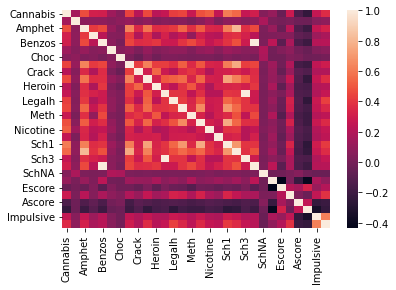

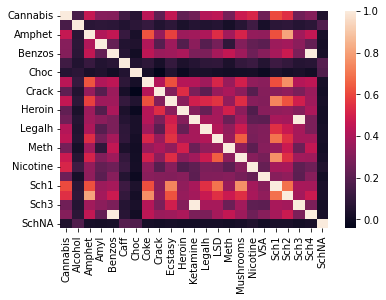

          Cannabis      Sch1      Sch2      Sch3      Sch4     SchNA
Cannabis  1.000000  0.607735  0.547054  0.255704  0.304623  0.043469
Sch1      0.607735  1.000000  0.689854  0.391722  0.384322  0.028940
Sch2      0.547054  0.689854  1.000000  0.379982  0.475426  0.027410
Sch3      0.255704  0.391722  0.379982  1.000000  0.284601  0.011805
Sch4      0.304623  0.384322  0.475426  0.284601  1.000000  0.021645
SchNA     0.043469  0.028940  0.027410  0.011805  0.021645  1.000000


,Cannabis,Alcohol,Amphet,Amyl,Benzos,Caff,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA
Cannabis,1.000000,0.154013,0.463053,0.306935,0.304623,0.130247,0.059199,0.437168,0.210596,0.455868,0.217370,0.255704,0.419041,0.443584,0.266510,0.476163,0.517491,0.253552
Alcohol,0.154013,1.000000,0.072153,0.080454,0.076666,0.051930,0.076327,0.104226,0.053042,0.081930,0.032803,0.058398,0.047677,0.058994,0.018609,0.062782,0.130199,0.023944
Amphet,0.463053,0.072153,1.000000,0.410257,0.455464,0.107491,0.028102,0.628132,0.346005,0.584920,0.362527,0.375249,0.404067,0.535882,0.373343,0.507976,0.340882,0.331993
Amyl,0.306935,0.080454,0.410257,1.000000,0.225814,0.051508,0.043274,0.410818,0.190223,0.366293,0.181242,0.319491,0.190139,0.266142,0.090363,0.301294,0.224999,0.204404
Benzos,0.304623,0.076666,0.455464,0.225814,1.000000,0.068419,0.007989,0.443611,0.357499,0.371107,0.398672,0.284601,0.283142,0.388256,0.454405,0.366307,0.249925,0.311762
Caff,0.130247,0.051930,0.107491,0.051508,0.068419,1.000000,0.053218,0.081854,0.021783,0.101753,0.037651,0.061769,0.084286,0.086957,0.036768,0.097416,0.115639,0.054668
Choc,0.059199,0.076327,0.028102,0.043274,0.007989,0.053218,1.000000,0.019347,-0.043873,0.046356,-0.014824,0.026723,0.028226,0.014755,0.006953,0.010369,0.016708,-0.007418
Coke,0.437168,0.104226,0.628132,0.410818,0.443611,0.081854,0.019347,1.000000,0.418188,0.619460,0.422541,0.419474,0.369824,0.517056,0.355603,0.495465,0.331358,0.318893
Crack,0.210596,0.053042,0.346005,0.190223,0.357499,0.021783,-0.043873,0.418188,1.000000,0.301460,0.536460,0.280621,0.202860,0.355576,0.397751,0.325044,0.189550,0.305624
Ecstasy,0.455868,0.081930,0.584920,0.366293,0.371107,0.101753,0.046356,0.619460,0.301460,1.000000,0.318229,0.491837,0.519502,0.553173,0.335369,0.538276,0.314622,0.301445


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
explore = drugs.copy()
explore['Cannabis'] = np.where((explore['Cannabis'] == 'CL0'), 0, 1)
explore = explore.astype({'Cannabis':int})
explore = explore[target_label + drug_labels + schedules + personality_labels]
sns.heatmap(explore.corr());
plt.show()
explore = explore[target_label + drug_labels + schedules]
sns.heatmap(explore.corr());
plt.show()
print(explore[target_label + schedules].corr())
explore[target_label + drug_labels].corr()

## Generate Datasets
data(sch=False, encode='none', bin_out=True, val=False)
- sch: False for individual drugs, True if using drug schedules
- encode: 'onehot' for one-hot encoding categorical (previously 2), 'label' for label encoding categorical (previously 3), 'none' for no encoding
- bin_out: True for binary outputs of weed users, False for all 7 categories of weed users
- val: False does not include a validation set, True does

In [4]:
y = drugs['Cannabis']
X = drugs.drop(target_label, 1)

def data(sch=False, encode='none', bin_out=True, val=False):
    if(sch):
        X_data = X.drop(drug_labels, 1)
    else:
        X_data = X.drop(schedules, 1)
    
    if(encode == 'onehot'):
        X_data = pd.get_dummies(X_data, columns=(demographic_labels))
    elif(encode == 'label'):
        for i in demographic_labels:
            X_data[i] = X_data[i].astype('category')
            X_data[i] = X_data[i].cat.codes
    else:
        for i in demographic_labels:
            X_data[i] = X_data[i].astype('category')
    
    if(val):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y, train_size=0.8)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2)
        
    if(bin_out):
        y_train = np.where((y_train == 'CL0'), 0, 1)
        y_test = np.where((y_test == 'CL0'), 0, 1)
        if(val):
            y_val = np.where((y_val == 'CL0'), 0, 1)
            return X_train, X_val, X_test, y_train, y_val, y_test
        else:
            return X_train, X_test, y_train, y_test
    else:
        if(val):
            return X_train, X_val, X_test, y_train, y_val, y_test
        else:
            return X_train, X_test, y_train, y_test

## Random Forest

- Base model of 1 Decision Tree: 0.848 accuracy, AUC 0.795
- Base Random Forest: 0.896 accuracy, AUC 0.948
- Tuned Random Forest: 0.915 accuracy, AUC 0.955

In [113]:
X_train, X_test, y_train, y_test = data(encode='onehot')

##### Single Decision Tree

In [285]:
tree = DecisionTreeClassifier(criterion='gini')
tree.fit(X_train, y_train)
print(f'Model Accuracy: {tree.score(X_train, y_train)}')
print("Accuracy:", tree.score(X_test, y_test))
roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])

Model Accuracy: 1.0
Accuracy: 0.848404255319149


0.7953889334402567

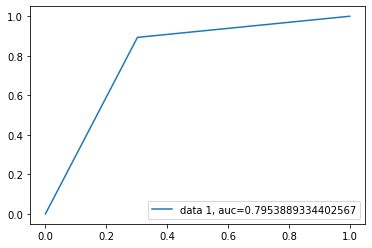

In [115]:
y_pred_proba = tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

##### Random Forest

In [148]:
model = RandomForestClassifier(n_estimators=100, bootstrap = True, class_weight = 'balanced_subsample', max_features = 'sqrt')
model.fit(X_train, y_train)
rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]
print("Accuracy:", model.score(X_test, y_test))
print(confusion_matrix(y_test, rf_predictions))

roc_value = roc_auc_score(y_test, rf_probs)
print("AUC", roc_value)

Accuracy: 0.8962765957446809
[[ 65  21]
 [ 18 272]]
AUC 0.9476744186046512


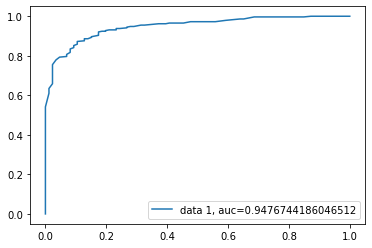

In [149]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

##### Tuning Hyperparameters

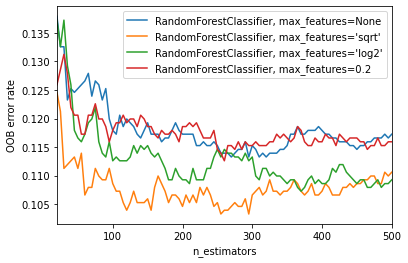

In [105]:
RANDOM_STATE = 123

ensemble_clfs = [
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features=None,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,
            max_features="sqrt",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features=0.2",
        RandomForestClassifier(
            warm_start=True,
            max_features=0.2,
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 20
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

From this, we can conclude that the method of choosing the max features that minimized the OOB error rate most was the sqrt method and was pretty stable after 200 n_estimators.

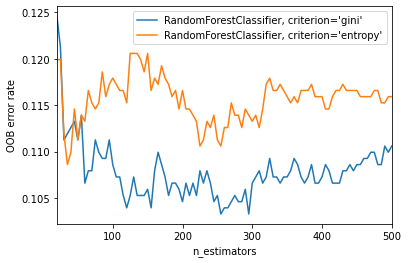

In [76]:
RANDOM_STATE = 123

ensemble_clfs = [
    (
        "RandomForestClassifier, criterion='gini'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            criterion='gini',
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, criterion='entropy'",
        RandomForestClassifier(
            warm_start=True,
            max_features="sqrt",
            criterion='entropy',
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 20
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

From this, we can conclude that gini minimizes more oob error, however the differences are around 0.005 difference. Gini will be chosen since the number of estimators chosen will be over 100 and it is also usually computationally less expensive to calculate.

##### Final Model

In [188]:
model = RandomForestClassifier(
            warm_start=True,
            max_features="sqrt",
            criterion='gini',
            max_depth=None,
            n_estimators=250,
            min_samples_split=2,
            oob_score=True
        )
model.fit(X_train, y_train)
rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]
print("Accuracy:", model.score(X_test, y_test))
print(confusion_matrix(y_test, rf_predictions))

roc_value = roc_auc_score(y_test, rf_probs)
print("AUC", roc_value)

Accuracy: 0.9148936170212766
[[ 69  17]
 [ 15 275]]
AUC 0.9547714514835605


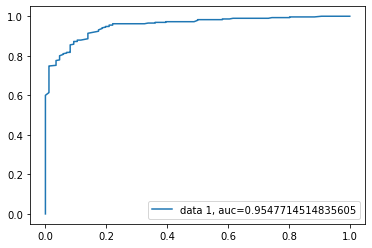

In [189]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

##### Further Exploration

In [204]:
#import joblib
#joblib.dump(model, 'final_RF_model.sav')
#X_train.to_csv('X_train_RF.csv')
#X_test.to_csv('X_test_RF.csv')
#np.savetxt('y_train_RF.csv', y_train)
#np.savetxt('y_test_RF.csv', y_test)

In [193]:
feature_importances = pd.DataFrame([model.feature_importances_], columns=X_train.columns, index=['Importance']).T.sort_values('Importance', ascending=False)
feature_importances

,Importance
Nicotine,0.104074
Oscore,0.060345
Mushrooms,0.059677
Coke,0.055174
Amphet,0.053402
Cscore,0.051702
Legalh,0.048428
Ecstasy,0.048150
Escore,0.047025
Ascore,0.047010


In [206]:
feature_importances.index

Index(['Nicotine', 'Oscore', 'Mushrooms', 'Coke', 'Amphet', 'Cscore', 'Legalh',
       'Ecstasy', 'Escore', 'Ascore', 'SS', 'Nscore', 'LSD', 'Amyl',
       'Impulsive', 'Country_UK', 'Age_18-24', 'Benzos', 'Country_USA',
       'Education_Masters degree', 'Age_25-34', 'Education_University degree',
       'Education_Some college or university, no certificate or degree',
       'Gender_0', 'Age_45-54', 'Age_35-44', 'Gender_1', 'VSA',
       'Ethnicity_White', 'Education_Professional certificate/ diploma',
       'Meth', 'Age_55-64', 'Education_Left school at 16 years', 'Ketamine',
       'Education_Doctorate degree', 'Alcohol', 'Age_65+', 'Country_Other',
       'Ethnicity_Black', 'Education_Left school at 18 years',
       'Country_Canada', 'Ethnicity_Mixed-White/Black', 'Country_Australia',
       'Choc', 'Ethnicity_Asian', 'Caff', 'Ethnicity_Other',
       'Ethnicity_Mixed-White/Asian', 'Crack',
       'Education_Left school at 17 years', 'Heroin',
       'Country_Republic of Ireland

<BarContainer object of 17 artists>

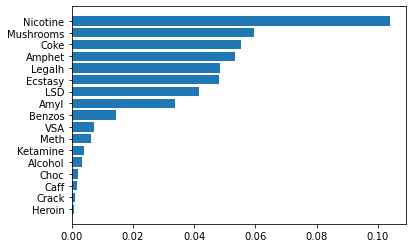

In [210]:
plt.barh(feature_importances.loc[drug_labels].sort_values('Importance', ascending=True).index, feature_importances.loc[drug_labels].sort_values('Importance', ascending=True)['Importance'])

##  XGBoost Model
Accuracy: 0.89

[01:28:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 88.56%
[[ 73  13]
 [ 30 260]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

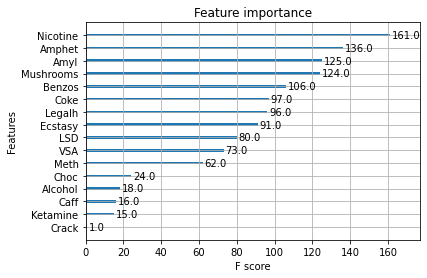

In [247]:
model = xgb.XGBClassifier(use_label_encoder=False)
model.fit(X_train[drug_labels], y_train)
y_pred = model.predict(X_test[drug_labels])
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(confusion_matrix(y_test, predictions))
xgb.plot_importance(model)

C:\Users\saman\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\saman\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:33:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 36.17%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

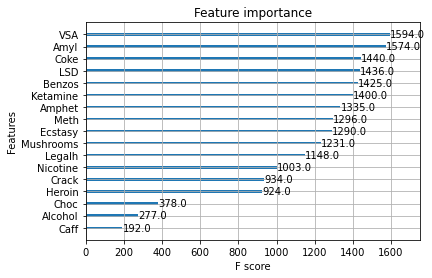

In [110]:
model = xgb.XGBClassifier()
model.fit(X_train[drug_labels], y_train)
y_pred = model.predict(X_test[drug_labels])
accuracy = np.sum(y_pred == y_test) / y_pred.shape[0]
print("Accuracy: %.2f%%" % (accuracy * 100.0))
xgb.plot_importance(model)

[21:42:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 87.77%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

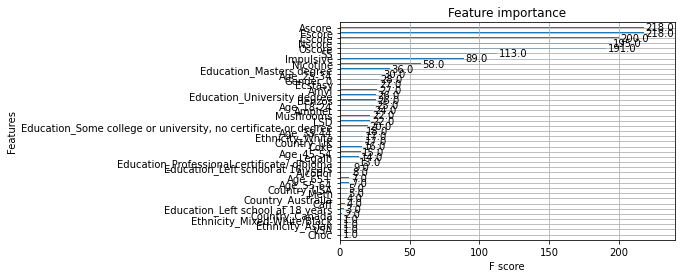

In [118]:
model = xgb.XGBClassifier()
model.fit(X_train2, y_bin_train)
y_pred = model.predict(X_test2)
accuracy = np.sum(y_pred == y_bin_test) / y_pred.shape[0]
print("Accuracy: %.2f%%" % (accuracy * 100.0))
xgb.plot_importance(model)

<br/><br/>

---
# Other
This is just quick implementations of other models to see if they are comparable and should be included

### Naive Bayes Models
Accuracy = 0.84

In [282]:
clf = CategoricalNB().fit(X_train[np.delete(np.array(X_train.columns).copy(), [0,1,2,3,4,5,6])], y_train)
clf_predictions = clf.predict(X_test[np.delete(np.array(X_test.columns).copy(), [0,1,2,3,4,5,6])])
accuracy = clf.score(X_test[np.delete(np.array(X_test.columns).copy(), [0,1,2,3,4,5,6])], y_test)
print(accuracy)
cm = confusion_matrix(y_test, clf_predictions)
cm

0.8377659574468085


array([[ 78,   8],
       [ 53, 237]], dtype=int64)

In [289]:
imps = permutation_importance(clf, X_train[np.delete(np.array(X_train.columns).copy(), [0,1,2,3,4,5,6])], y_train)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train[np.delete(np.array(X_train.columns).copy(), [0,1,2,3,4,5,6])].shape[1]):
    print("%d. %s (%f)" % (f + 1, schedules[indices[f]], importances[indices[f]]))

Feature ranking:


IndexError: list index out of range

### KNN
Accuracy = 0.89

In [255]:
#X_train, X_test, y_train, y_test = data()
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train[drug_labels], y_train)
neigh.score(X_test[drug_labels], y_test)

0.8909574468085106